# Macro pressure and rates returns

This notebook serves as an illustration of the points discussed in the post ["The power of macro trends in rates markets"](https://research.macrosynergy.com/the-power-of-macro-trends-in-rates-markets/) available on the Macrosynergy website. The post highlights the importance of broad macroeconomic trends, such as *inflation*, *economic growth*, and *credit creation*, in influencing shifts in monetary policy. These trends play a crucial role in determining whether monetary policy will lean towards tightening or easing.

The post emphasizes that markets may not always fully anticipate policy shifts that follow macro trends due to a possible lack of attention or conviction. In such cases, macro trends can serve as predictors of returns in fixed-income markets. Even a simple point-in-time macro pressure indicator, which is an average of excess inflation, economic growth, and private credit trends, has exhibited a significant correlation with subsequent interest rate swap returns for 2-years fixed rate receivers in both large and small currency areas.

The post highlights additionally that considering the gap between real rates and macro trend pressure provides an even higher forward correlation and remarkable directional accuracy in predicting fixed income returns.

# Imports

In [49]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
print(str(Path.cwd().parent))

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

from timeit import default_timer as timer
from datetime import timedelta, date

import warnings

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
                                                   
# df = pd.read_csv('../input/fixed-income-returns-and-macro-trends/JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])

macrosynergy_fixed_income_returns_and_macro_trends_path = str(Path.cwd().parent) + '/kaggle'

print('Data source path:', macrosynergy_fixed_income_returns_and_macro_trends_path)
df = pd.read_csv(macrosynergy_fixed_income_returns_and_macro_trends_path + '\JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])
display (df.head(3))
df.info()

c:\finance\macrosynergy\notebooks
Data source path: c:\finance\macrosynergy\notebooks/kaggle


,real_date,cid,xcat,value,grading,eop_lag,mop_lag
0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,95.0,292.0
1,2000-01-04,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,96.0,293.0
2,2000-01-05,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,97.0,294.0


<class 'pandas.core.frame.DataFrame'>
Index: 3390059 entries, 0 to 3390058
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 206.9+ MB


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md) or use the free dataset on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends)

To ensure reproducibility, only samples between January 2000 (inclusive) and May 2023 (exclusive) are considered.

The notebook uses the `macrosynergy` package, which supports financial market research and the development of trading strategies based on formats and conventions of the J.P. Morgan Macrosynergy Quantamental System (JPMaQS). For full documentation on `macrosynergy` package check out https://github.com/macrosynergy/macrosynergy or view the notebook on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package) for examples. 

In [50]:
 # Quantamental categories of interest

ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "PCREDITBN_SJA_P1M1ML12",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

The description of each JPMaQS category is available either under [Macro Quantamental Academy](https://academy.macrosynergy.com/quantamental-indicators/), [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected), or on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends) (limited set of tickers used in this notebook).

In [51]:
# Cross-sections of interest

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em


## Indicators explained

This example notebook contains a few select categories for a subset of developed and emerging markets: AUD (Australian dollar), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), COP (Colombian peso), CZK (Czech Republic koruna), EUR (euro), GBP (British pound), HUF (Hungarian forint), IDR (Indonesian rupiah), ILS (Israeli shekel), INR (Indian rupee), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), NOK (Norwegian krone), NZD (New Zealand dollar), PLN (Polish zloty), SEK (Swedish krona), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar) and ZAR (South African rand). 

The description of each JPMaQS category is available either under [Macro Quantamental Academy](https://academy.macrosynergy.com/quantamental-indicators/), [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected), or on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends) (just for the tickers used in this notebook).

In [52]:
display(df['xcat'].unique())
display(df['cid'].unique())
df['ticker'] = df['cid'] + "_" + df["xcat"]
df.head(3)

array(['CPIC_SA_P1M1ML12', 'CPIC_SJA_P3M3ML3AR', 'CPIC_SJA_P6M6ML6AR',
       'CPIH_SA_P1M1ML12', 'CPIH_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR',
       'DU02YXR_NSA', 'DU02YXR_VT10', 'DU05YXR_NSA', 'DU05YXR_VT10',
       'EQXR_NSA', 'EQXR_VT10', 'FXCRR_NSA', 'FXTARGETED_NSA',
       'FXUNTRADABLE_NSA', 'FXXR_NSA', 'FXXR_VT10', 'INFTEFF_NSA',
       'INTRGDP_NSA_P1M1ML12_3MMA', 'INTRGDPv5Y_NSA_P1M1ML12_3MMA',
       'PCREDITBN_SJA_P1M1ML12', 'PCREDITGDP_SJA_D1M1ML12',
       'RGDP_SA_P1Q1QL4_20QMA', 'RYLDIRS02Y_NSA', 'RYLDIRS05Y_NSA'],
      dtype=object)

array(['AUD', 'CAD', 'CHF', 'CLP', 'COP', 'CZK', 'EUR', 'GBP', 'HUF',
       'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN',
       'SEK', 'THB', 'TRY', 'TWD', 'USD', 'ZAR'], dtype=object)

,real_date,cid,xcat,value,grading,eop_lag,mop_lag,ticker
0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,95.0,292.0,AUD_CPIC_SA_P1M1ML12
1,2000-01-04,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,96.0,293.0,AUD_CPIC_SA_P1M1ML12
2,2000-01-05,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,97.0,294.0,AUD_CPIC_SA_P1M1ML12


# Key hypothesis and the choice of variables

The basic hypothesis is that excess growth and inflation significantly shape the trend in real and nominal interest rates at all maturities. Positive excesses put upward pressure on rates while negative excesses (shortfalls) exert downward pressure. We call this pressure abstractly "macro trend pressure". This pressure is unlikely to be fully priced in the market for lack of attention or conviction. In practice, financial markets often neglect the fundamental gravity of rates for the sake of abstract factors, such as carry, and risk management. Below example is a snippet of simple predictions that can be done with selected JPMaQs indicators.

## Features (explanatory variables) of the analysis

### Excess growth

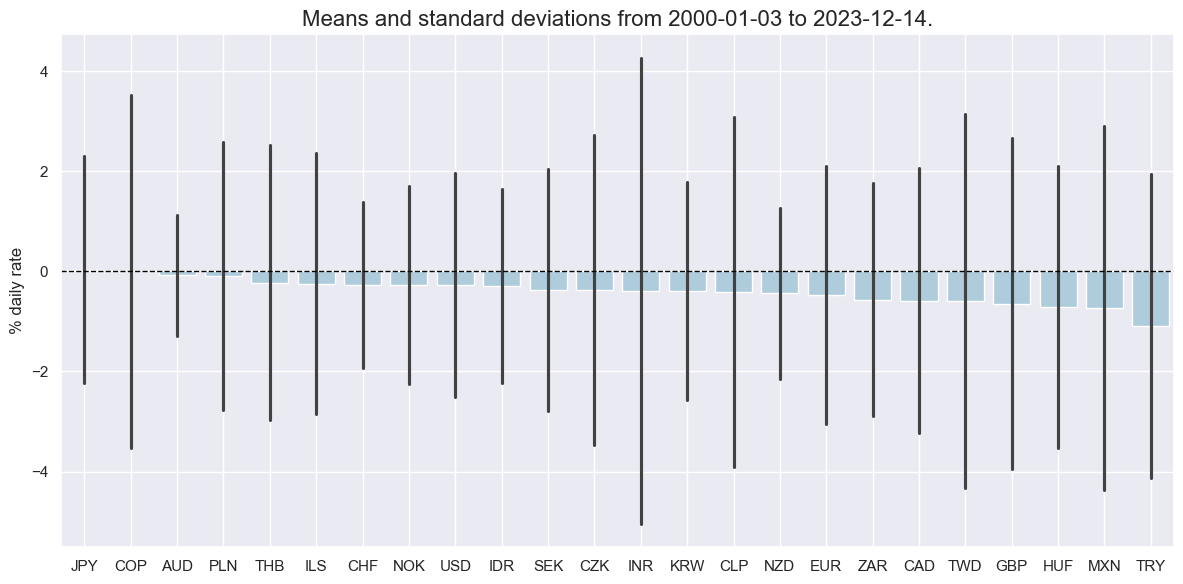

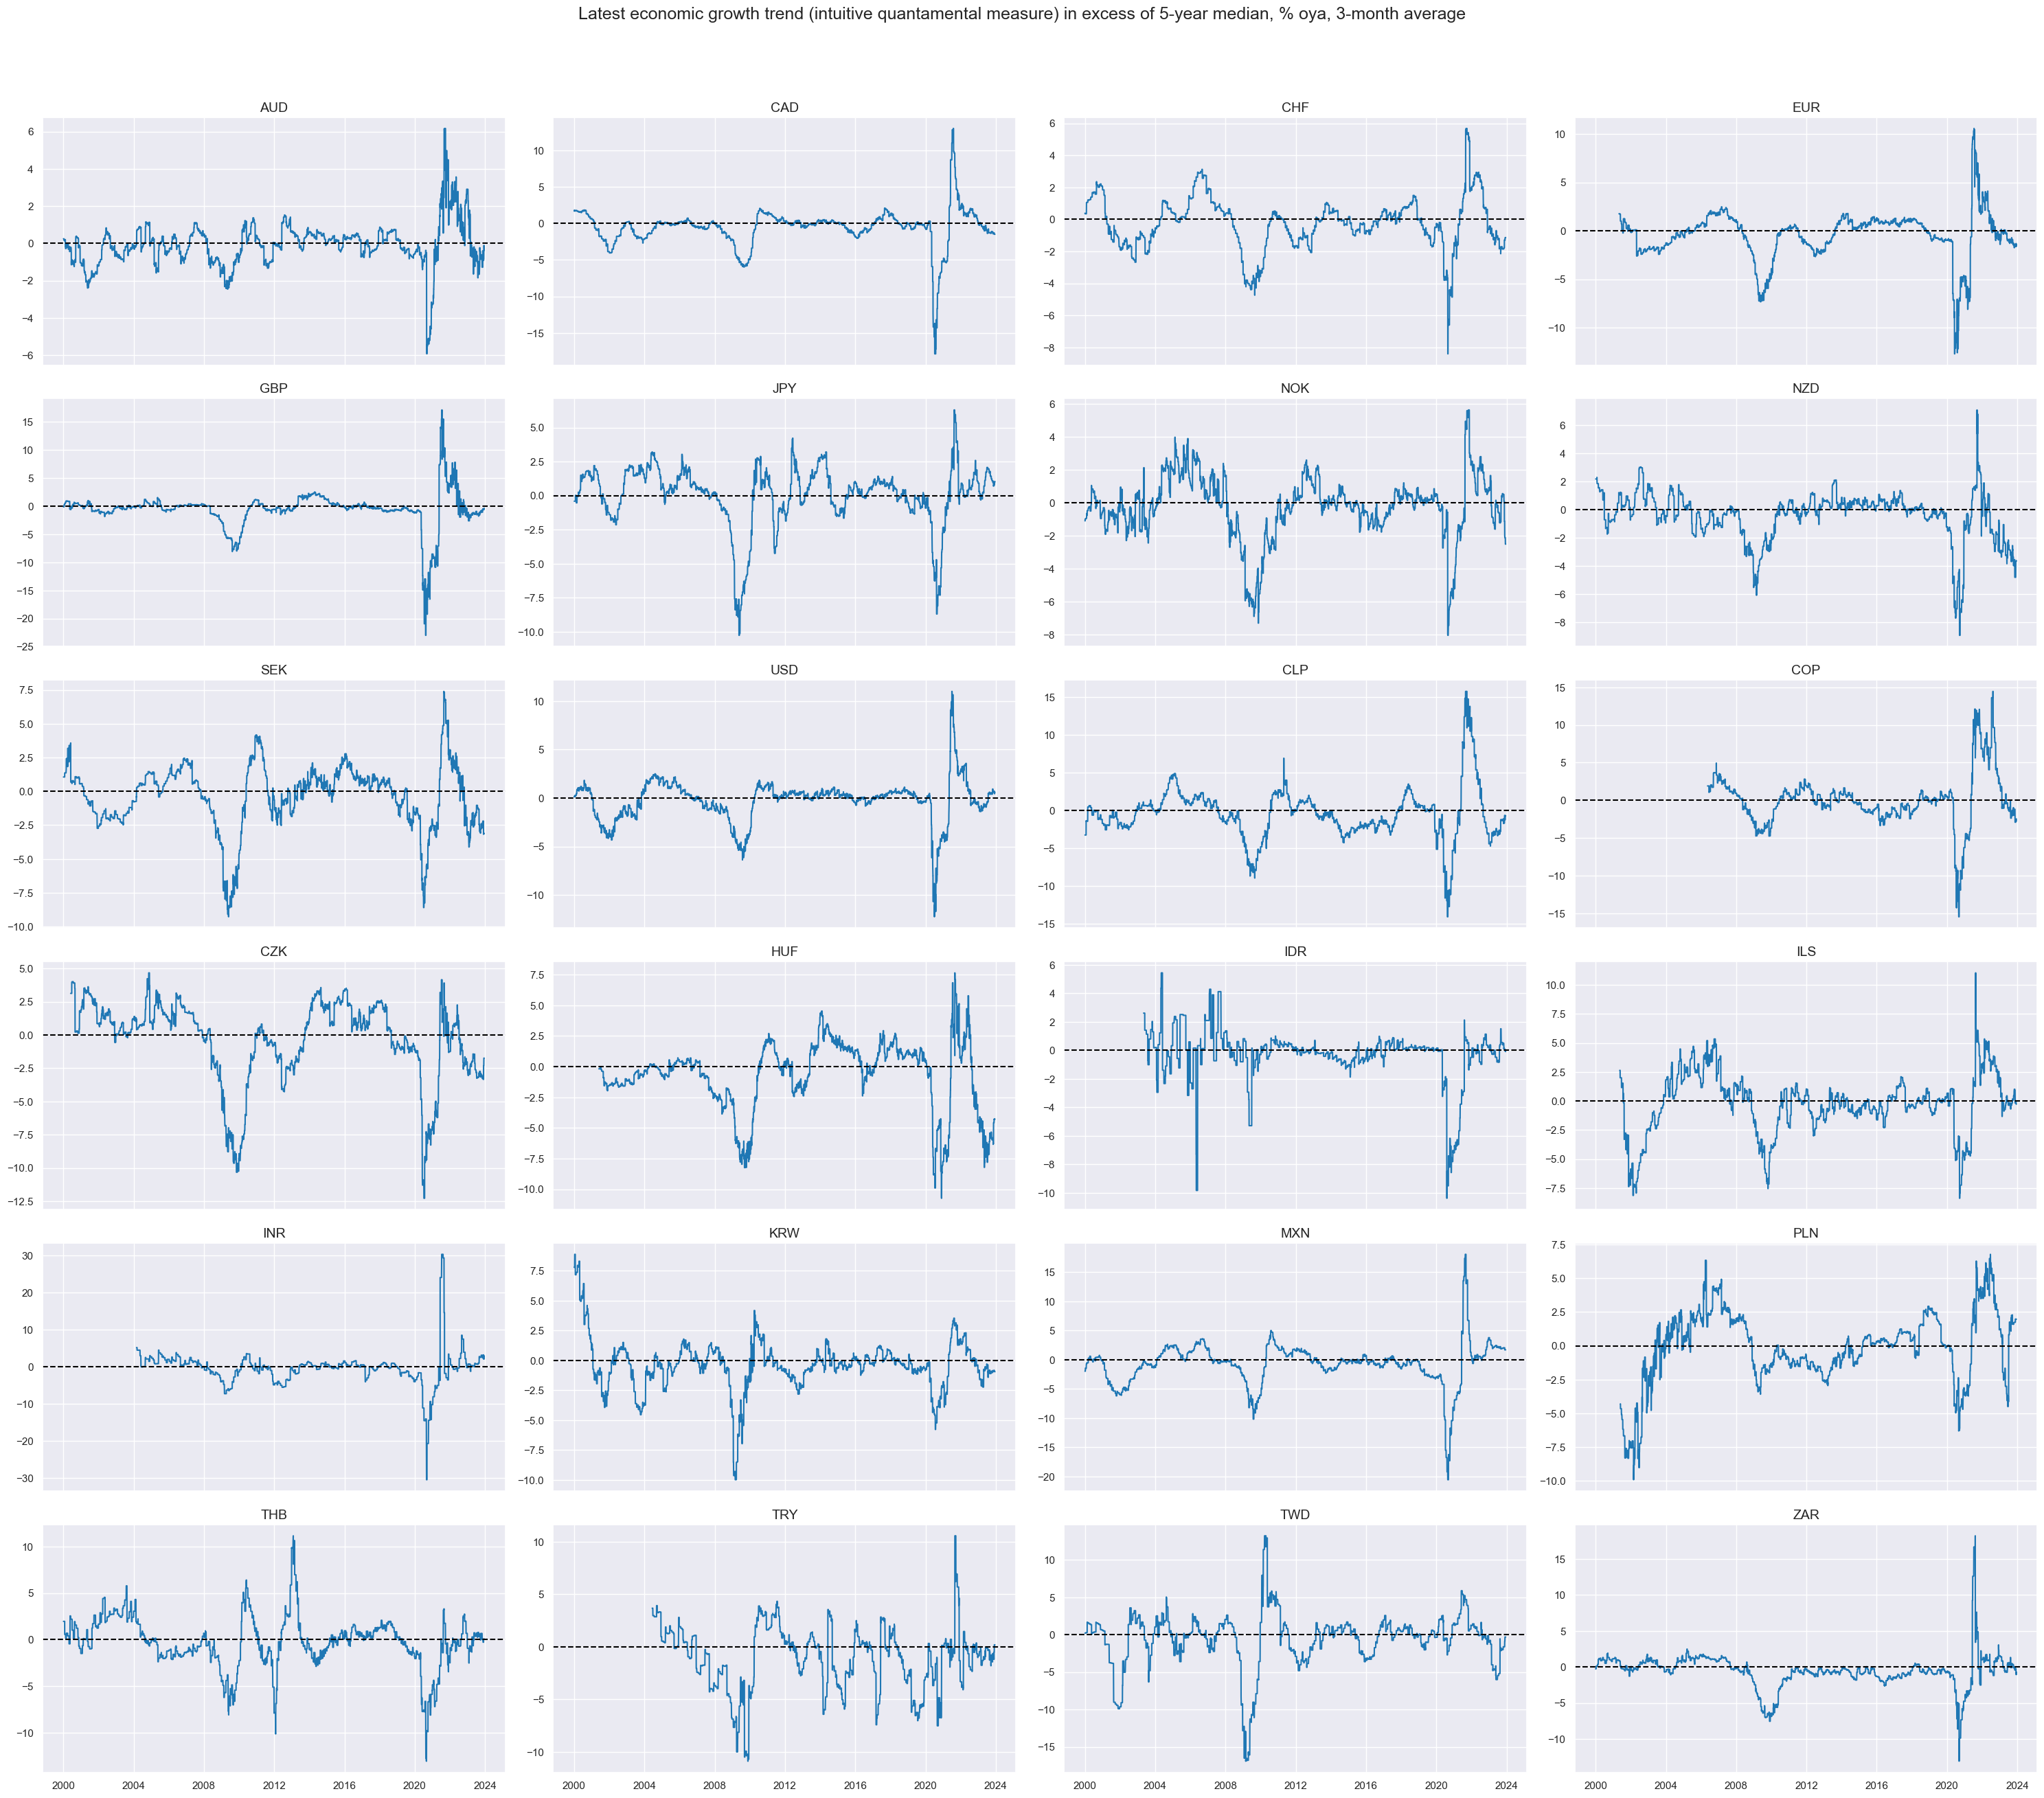

In [53]:
# Excess Growth is a ready-made category available in this dataset. It is defined as the latest estimated "intuitive" GDP growth trend, % over a year ago, 
# 3-month moving average minus a long-term median of that country's actual GDP growth rate at that time: based on 5 year lookback of the latter 

xcatx = ["INTRGDPv5Y_NSA_P1M1ML12_3MMA"]


msp.view_ranges(  
    df,
    cids=cids,
    xcats=xcatx,
    size = (12, 6),
    kind="bar",
    sort_cids_by="mean",
    ylab="% daily rate",
    start="2000-01-01",
)
msp.view_timelines(
    df,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    aspect=1.75,
    size=(12, 12),
    all_xticks=False,
    title_adj=1.02,
    label_adj=0.05,
    title="Latest economic growth trend (intuitive quantamental measure) in excess of 5-year median, % oya, 3-month average",
    xcat_labels=["% over a year ago"]  #, "% 6m/6m, saar", "% 3m/3m, saar"],
)

### Excess inflation

In this notebook, excess inflation is defined as the difference between the recorded seasonally and jump-adjusted inflation trend (`CPIC_SJA_P6M6ML6AR`) and the effective inflation target (`INFTEFF_NSA`). The resulting indicator is named `CPIC_SJA_P6M6ML6ARvIT`.

The excess inflation indicator provides valuable information about inflation dynamics and the extent to which inflation deviates from the desired level. A positive value of `CPIC_SJA_P6M6ML6ARvIT` indicates that inflation is higher than the target, while a negative value suggests that inflation is lower than the target.

Using the `macrosynergy` package, we can visualize the newly created indicator. 

In [54]:
xcatx = ['INFTEFF_NSA']
filt1=df['xcat'].isin(xcatx)
dfb=df[filt1]

infs = [
    "CPIC_SJA_P6M6ML6AR",
]

for inf in infs:
    calcs = [
        f"{inf}vIT = ( {inf} - INFTEFF_NSA )",
     ]
dfa = msp.panel_calculator(df, calcs, cids=cids)
df = msm.update_df(df, dfa)

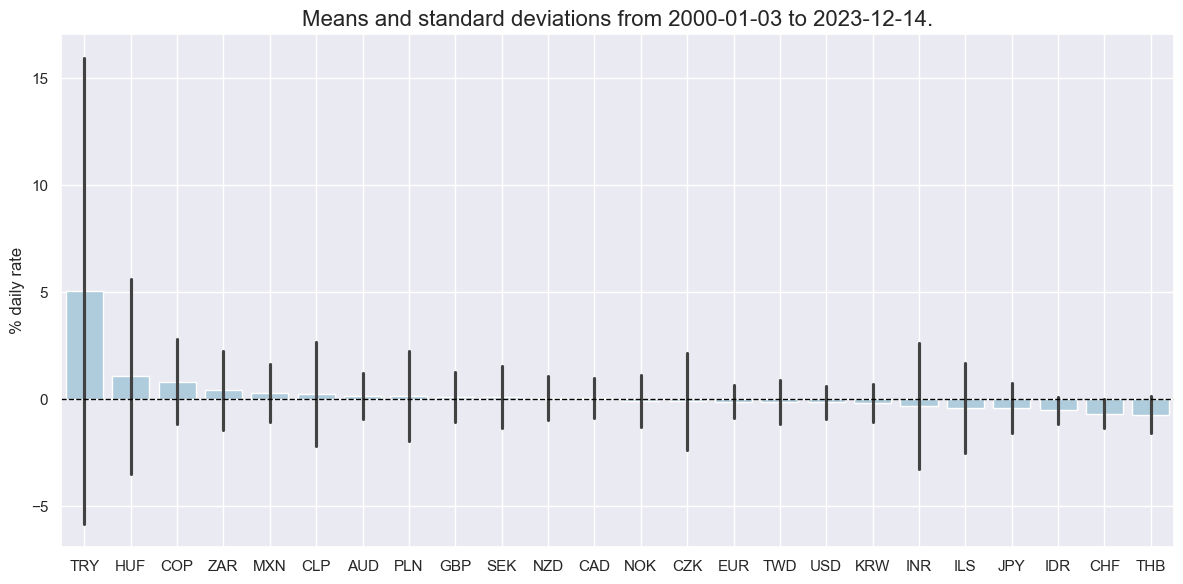

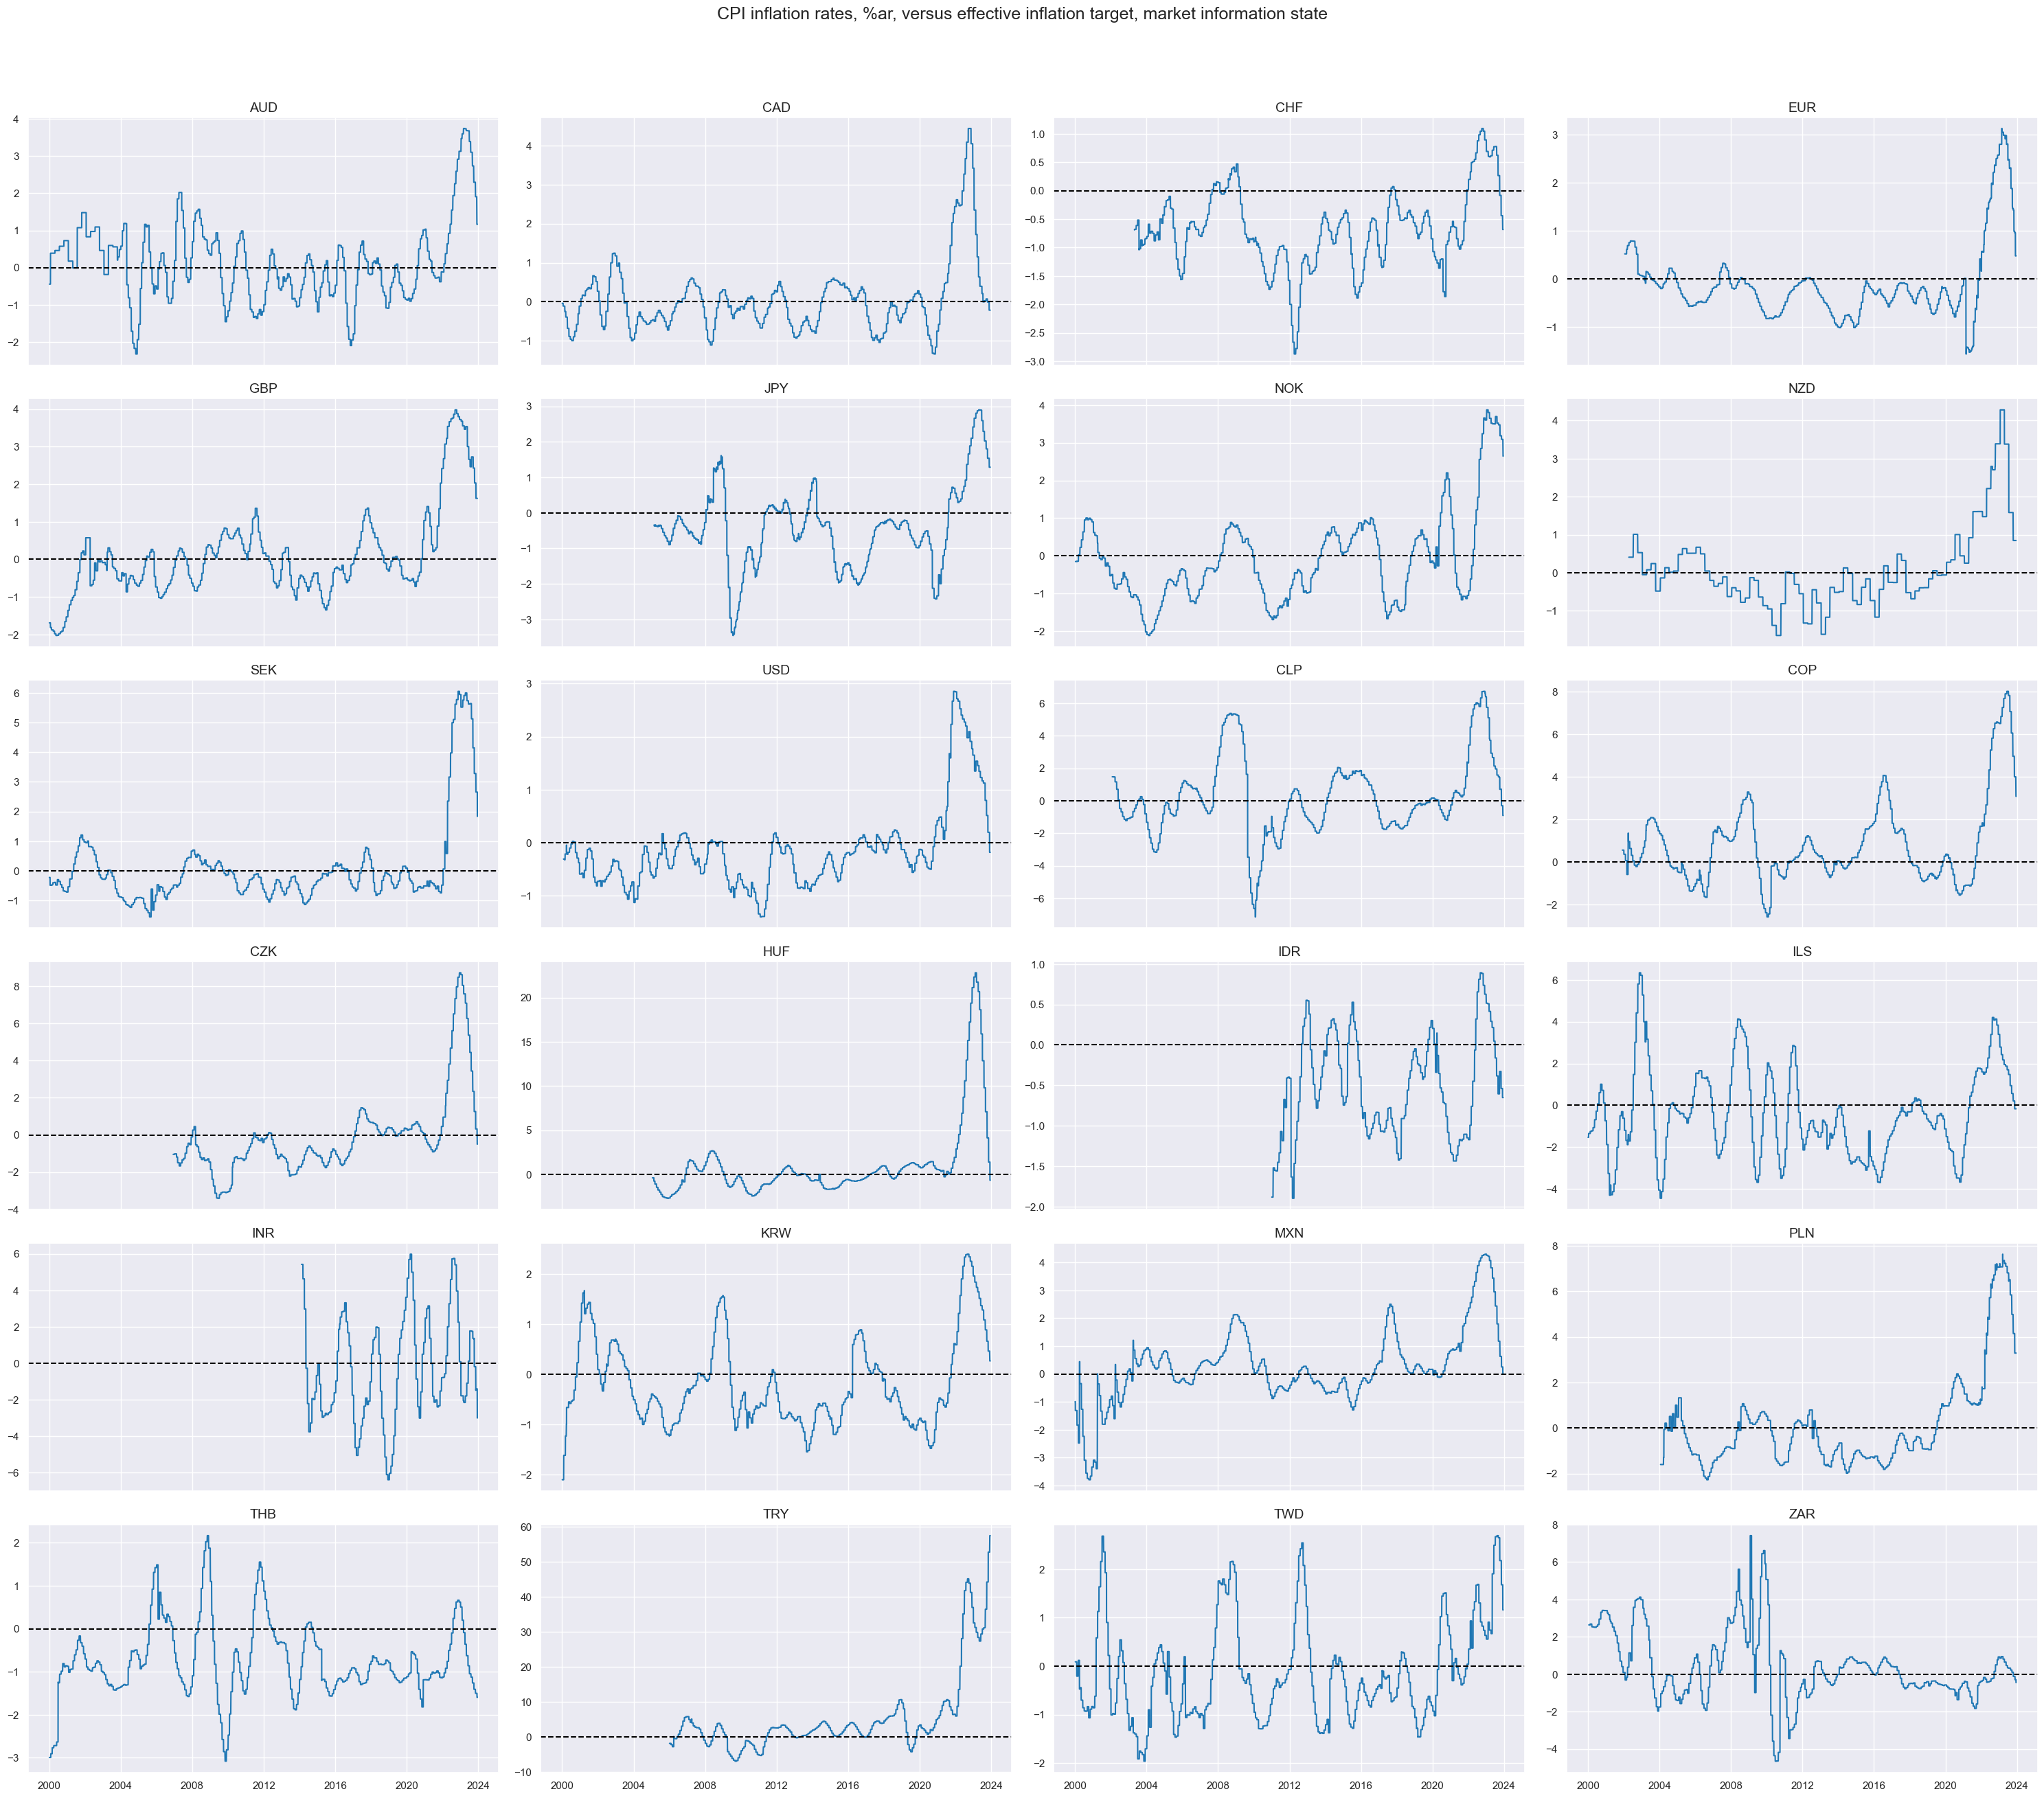

In [55]:
xcatx = ["CPIC_SJA_P6M6ML6ARvIT"]

msp.view_ranges( 
    df,
    cids=cids,
    xcats=xcatx,
    size = (12, 6),
    kind="bar",
    sort_cids_by="mean",
    ylab="% daily rate",
    start="2000-01-01",
)
msp.view_timelines(
    df,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    aspect=1.75,
    size=(12, 12),
    all_xticks=False,
    title_adj=1.02,
    label_adj=0.05,
    title="CPI inflation rates, %ar, versus effective inflation target, market information state",
    xcat_labels=["% over a year ago"]  #, "% 6m/6m, saar", "% 3m/3m, saar"],
)

### Composite macro trend pressures and rate-pressure gaps

To create an additional panel of "excess nominal growth," which serves as a simplified version of the Taylor rule for monetary policy, we calculate the simple average of the excess estimated GDP growth and core CPI trends. This indicator provides a measure of the pressure for monetary tightening (positive values) or easing (negative values).

Using the `macrosynergy` package, we can visualize the newly created indicator. 

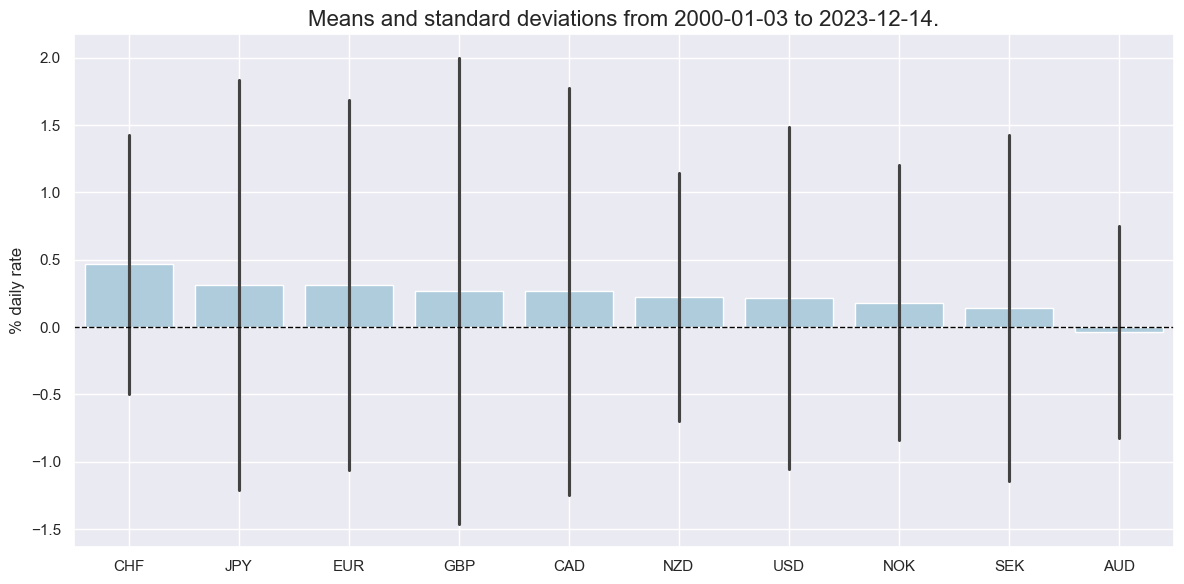

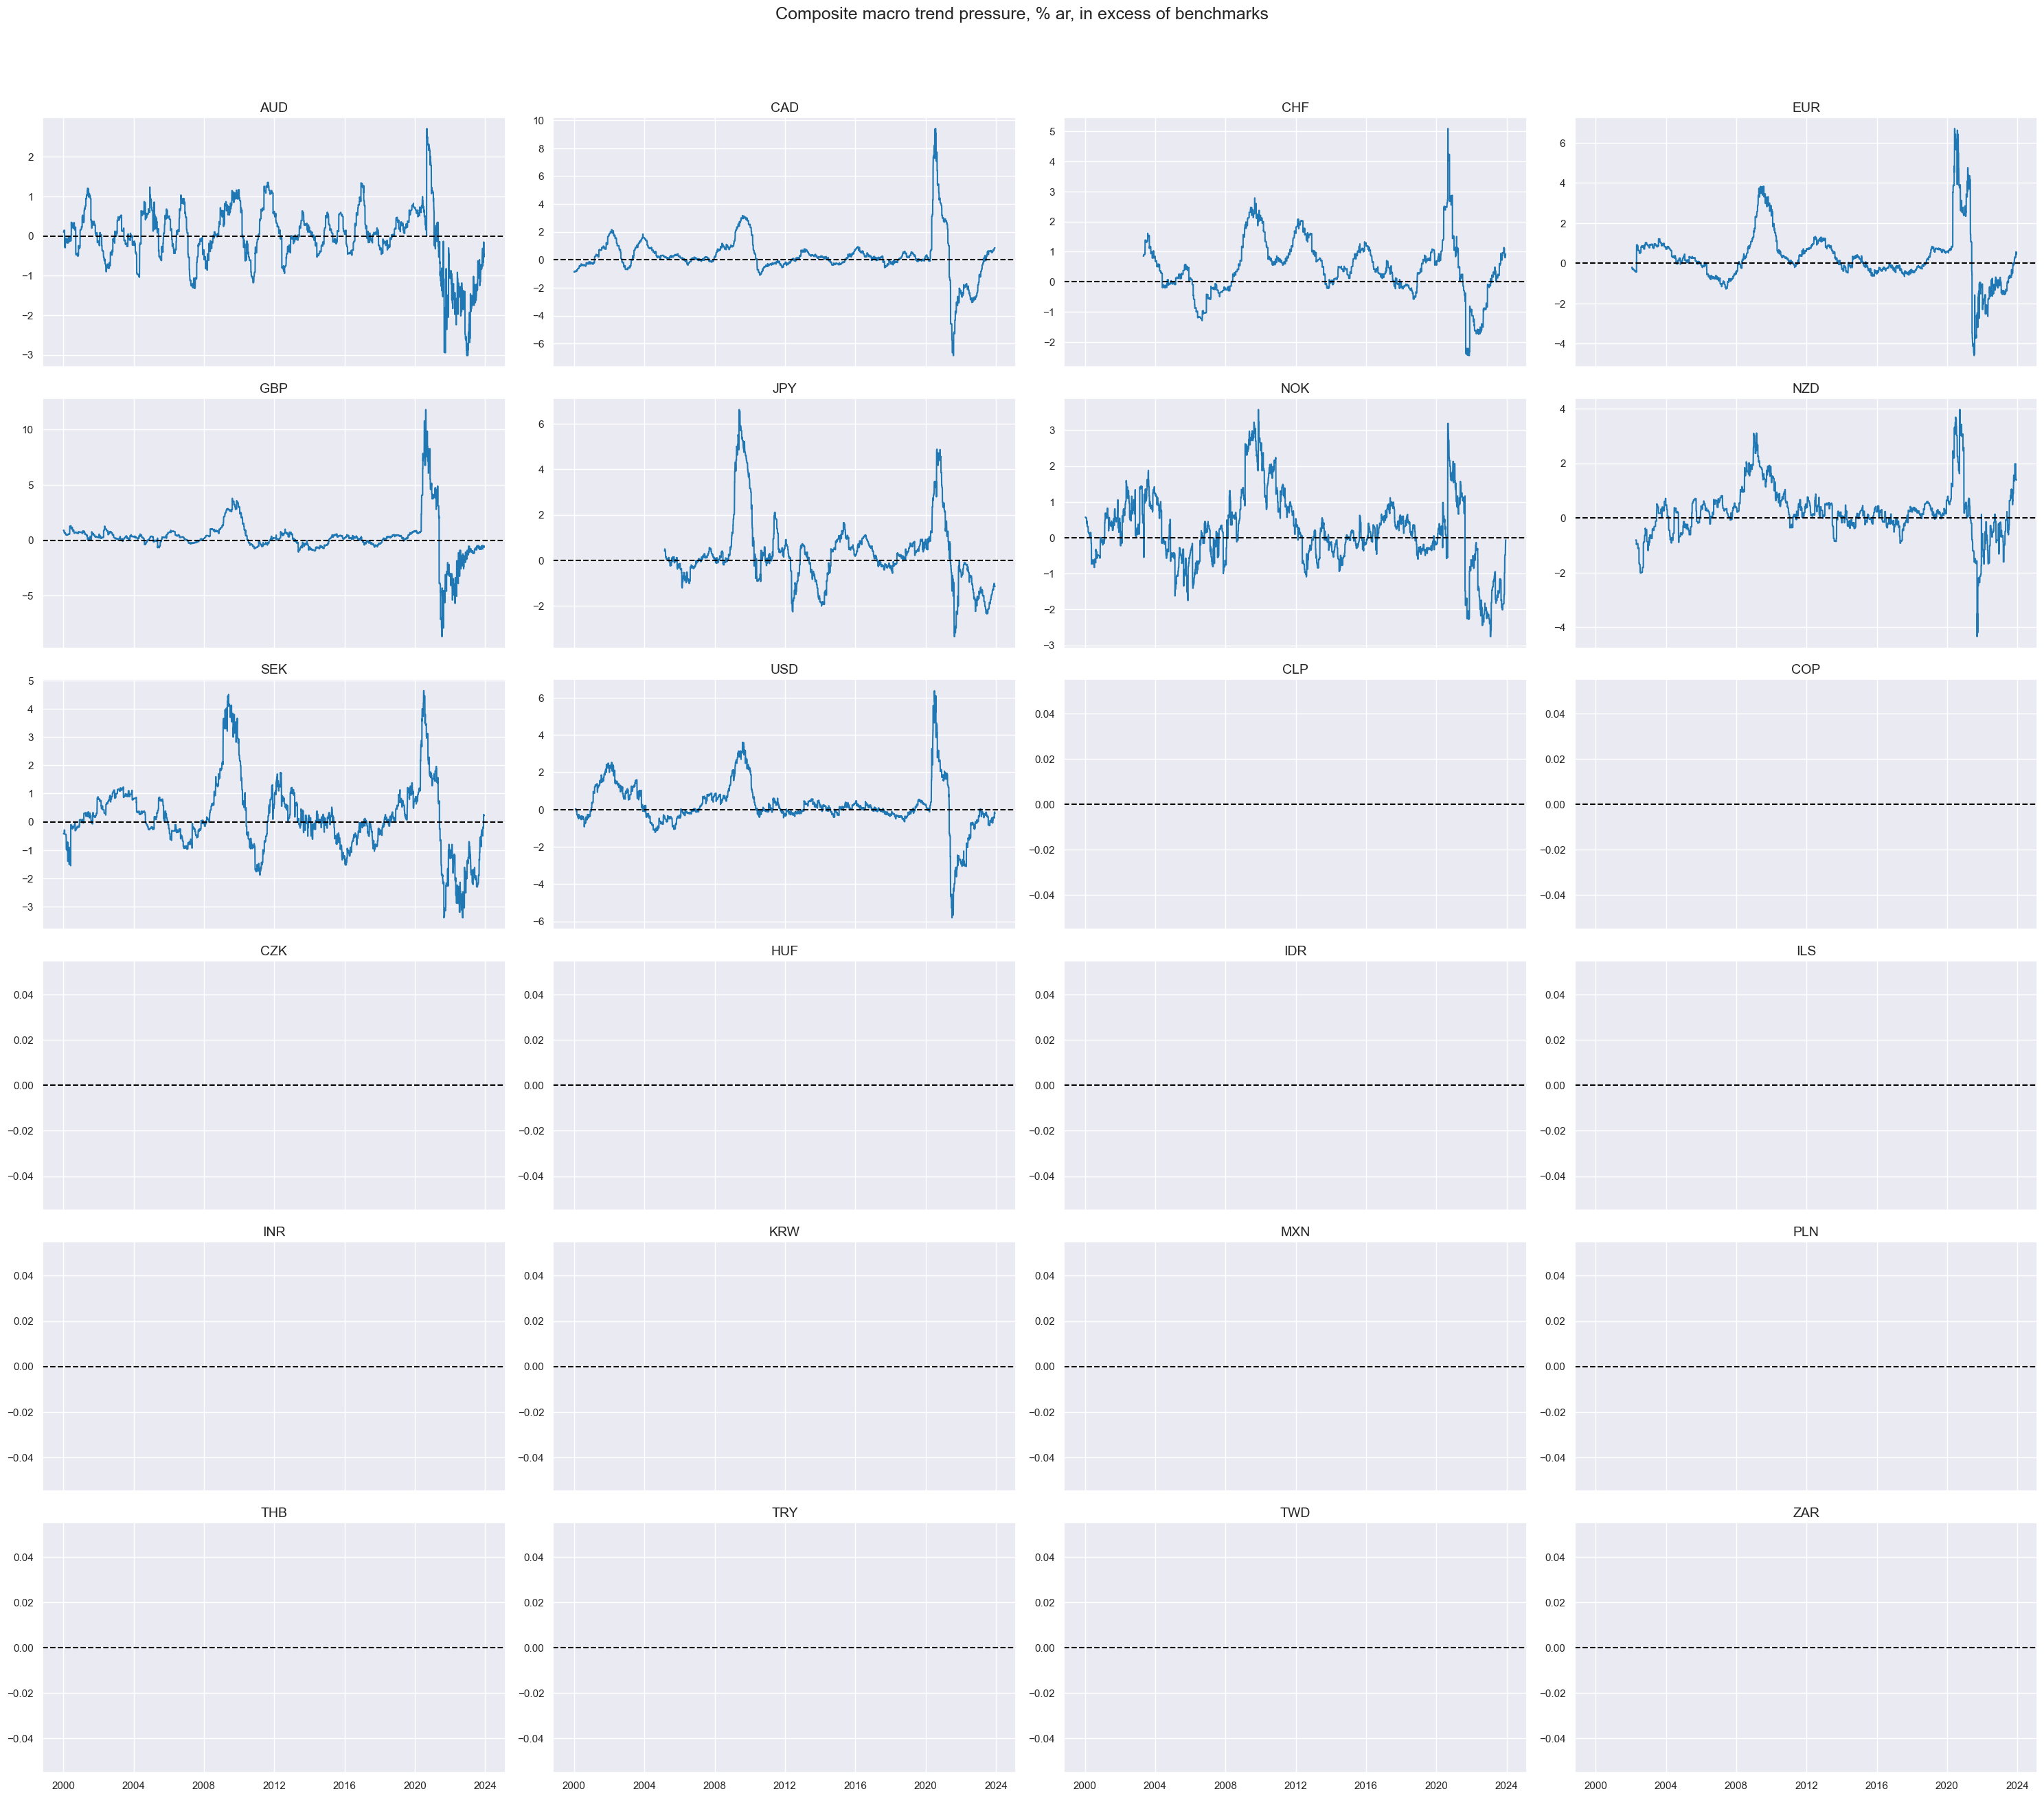

In [56]:
calcs = [
    "XGCI = ( INTRGDPv5Y_NSA_P1M1ML12_3MMA + CPIC_SJA_P6M6ML6ARvIT ) / 2",
    "XGCI_NEG = - XGCI"
]

dfa = msp.panel_calculator(df, calcs, cids=cids_dm)
df = msm.update_df(df, dfa)

xcatx = ["XGCI_NEG"]

msp.view_ranges(
    df,
    cids=cids,
    xcats=xcatx,
    size = (12, 6),
    kind="bar",
    sort_cids_by="mean",
    ylab="% daily rate",
    start="2000-01-01",
)
msp.view_timelines(
    df,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    aspect=1.75,
    size=(12, 12),
    all_xticks=False,
    title_adj=1.02,
    label_adj=0.05,
    title="Composite macro trend pressure, % ar, in excess of benchmarks",
)

## Targets (Response Variables)

### Directional returns

The below cell visualizes ranges, outliers, and cumulative interest rate swap returns for the 2-years fixed rate receivers.

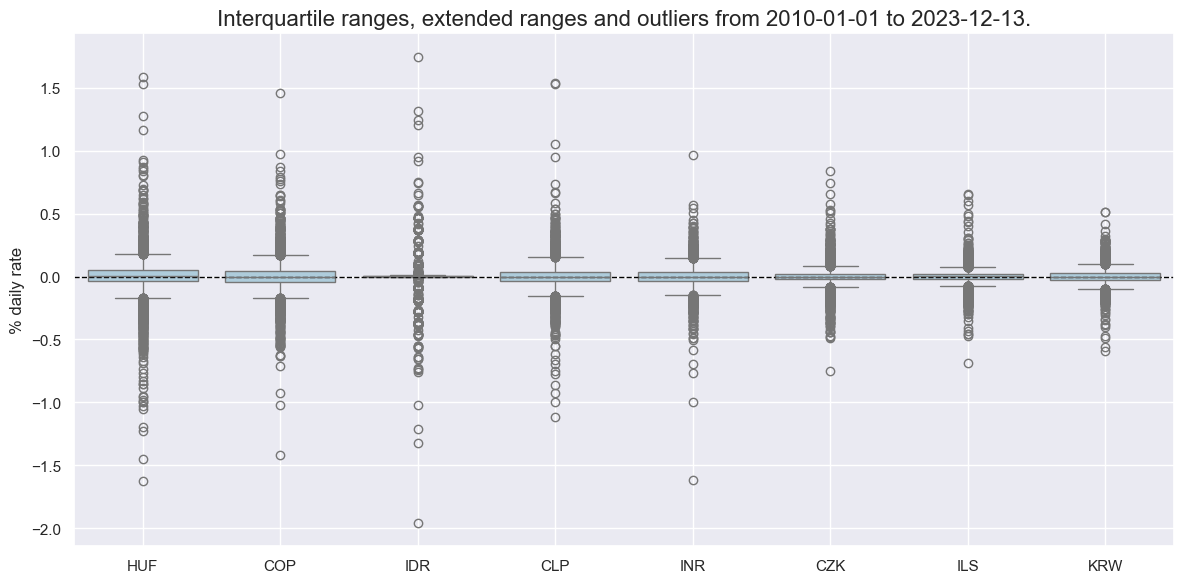

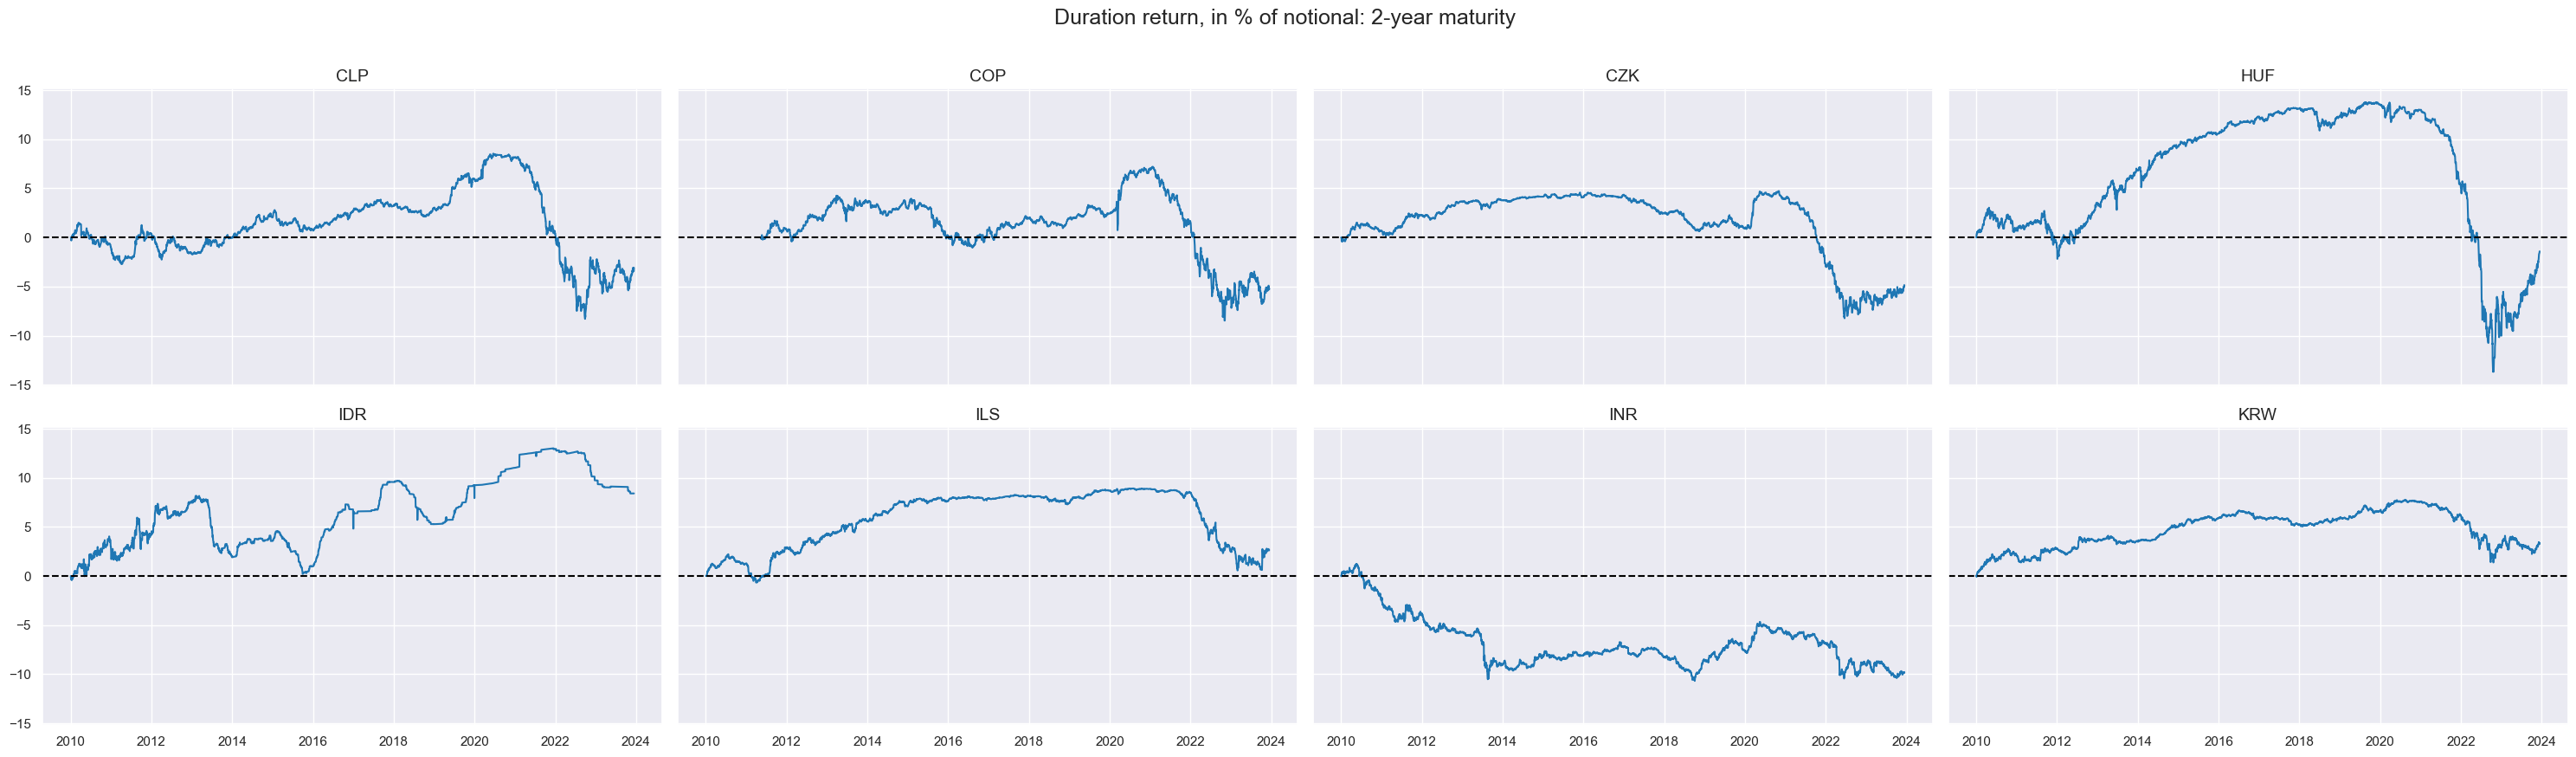

In [57]:
xcats_sel = ["DU02YXR_NSA"]
msp.view_ranges(
    df,
    cids=cids_em[:8],
    xcats=xcats_sel,
    size = (12, 6),
    kind="box",
    sort_cids_by="std",
    ylab="% daily rate",
    start="2010-01-01",
)
msp.view_timelines(
    df,
    xcats=xcats_sel,
    cids=cids_em[:8],
    ncol=4,
    cumsum=True,
    start="2010-01-01",
    same_y=True,
    aspect=1.75,
    size=(12, 12),
    all_xticks=False,
    title="Duration return, in % of notional: 2-year maturity ",
    title_adj=1.02,
    xcat_labels=None,
    label_adj=0.05,
)

# Empirical analysis: macro trends and IRS returns

## Basic theory

The below is a quick analysis of the relation between excess nominal growth in negative form (XGCI_NEG) and returns on a 2-year fixed receiver position in the interest rate swaps market. Economic theory and central bank mandates suggest that economic growth and inflation relative to target levels cause monetary policy adjustments. Above-target dynamics support shifts towards monetary tightening, while shortfalls support monetary easing. These policy shifts can take the form of communication or actual market operations. Tightening almost always implies an increase in local-currency interest rates. If the market is not completely efficient in tracking economic trends there should be a lagged effect: today's economic dynamics should still affect tomorrow's returns.

The below panel correlation analysis using the `reg_scatter` method of the `CategoryRelations` class of the `macrosynergy` package confirms that there has been a clear and positive concurrent relation between excess nominal GDP growth and fixed receiver returns. This is the intuition of the popular **Taylor rule** of monetary policy.

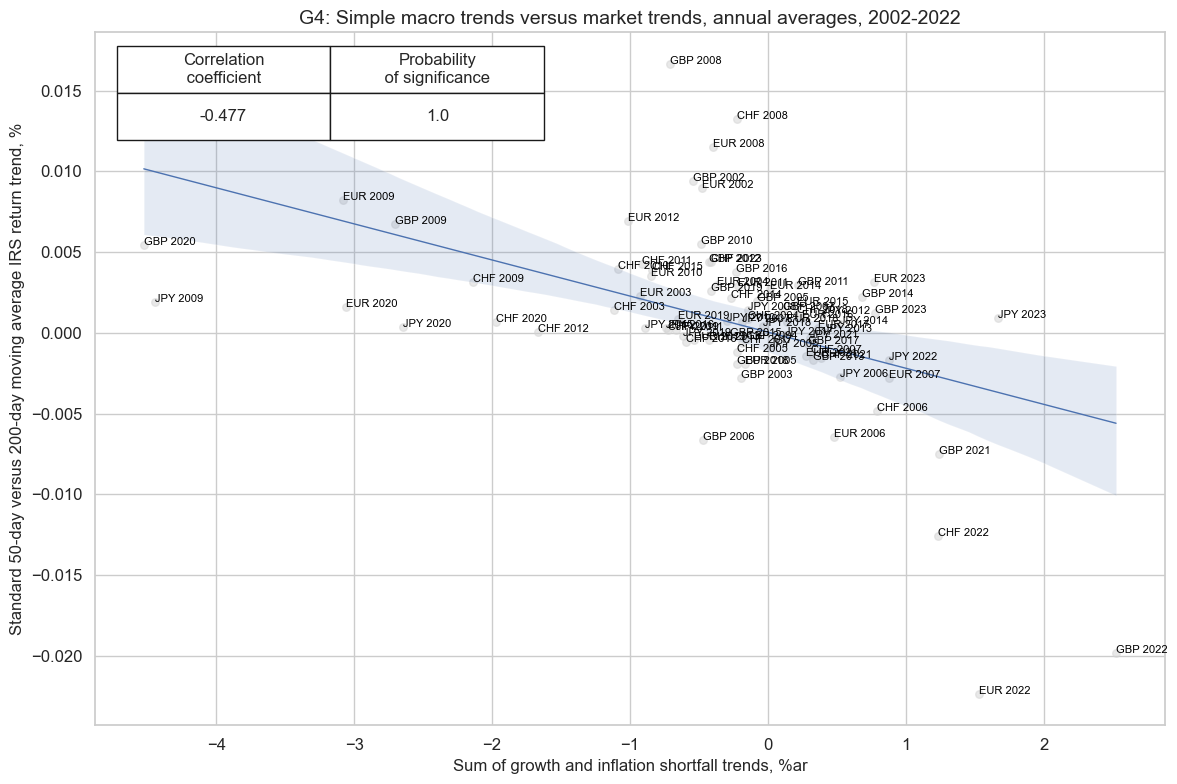

In [58]:
cra = msp.CategoryRelations(
    df,
    xcats=["XGCI", "DU02YXR_NSA"],
    cids=cids_dm[2:6],
    freq="A",
    lag=0,
    xcat_aggs=["mean", "mean"],
    start="2002-01-01",
    xcat_trims=[None, None],
)
cra.reg_scatter(
    labels=True,
    coef_box="upper left",
    title="G4: Simple macro trends versus market trends, annual averages, 2002-2022",
    xlab="Sum of growth and inflation shortfall trends, %ar",
    ylab="Standard 50-day versus 200-day moving average IRS return trend, %",
)

### Can the simple macro trend predict swap returns?¶

Below we check if the simple composite (negative) nominal GDP growth trend also has predictive power with respect to future swap returns. It is important to remember that quantamental data always reflect the information state of the market and, hence, any predictive power they have over future returns is valid for backtesting and directly applicable to trading strategies. Indeed, the panel correlation of the excess macro trend with subsequent monthly returns has been positive and significant at the 1.5% level.

XGCI misses: ['CLP', 'COP', 'CZK', 'HUF', 'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'PLN', 'THB', 'TRY', 'TWD', 'ZAR'].


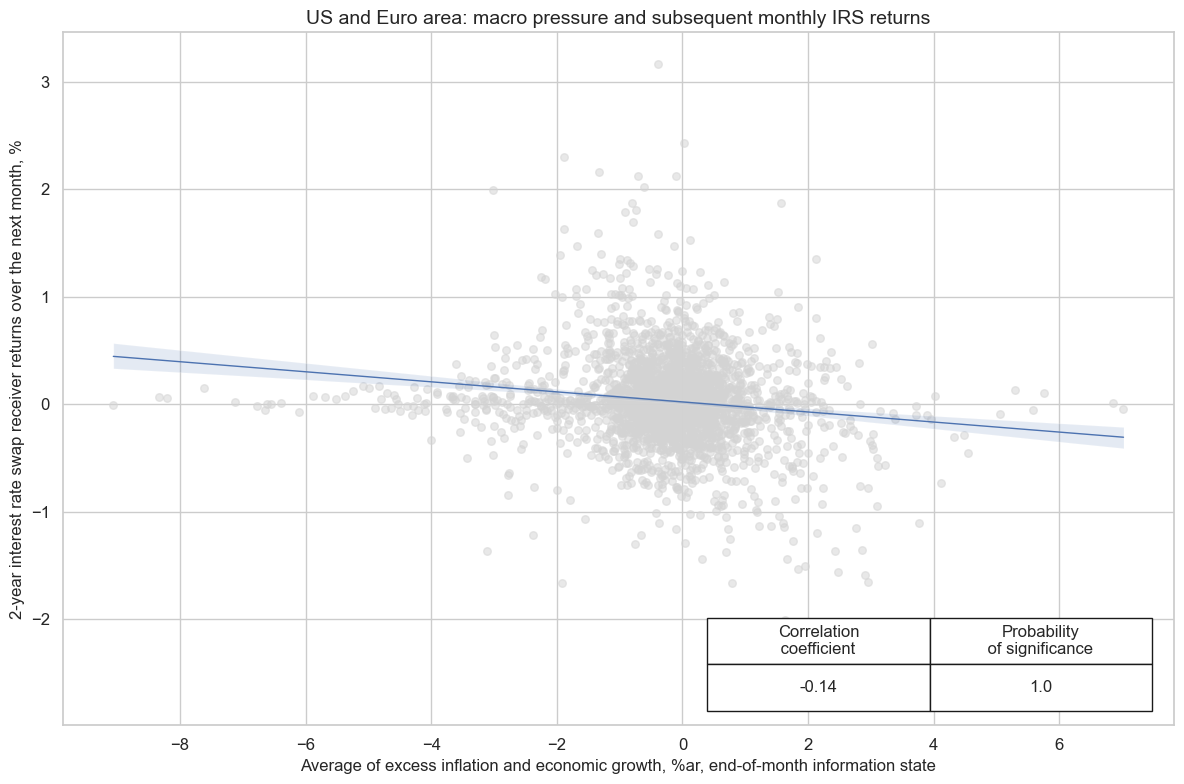

In [59]:
crm = msp.CategoryRelations( 
    df,
    xcats=["XGCI", "DU02YXR_NSA"],
    cids=cids,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    xcat_trims=[None, None],
)
crm.reg_scatter(
    labels=False, coef_box="lower right",
    title="US and Euro area: macro pressure and subsequent monthly IRS returns",
    xlab="Average of excess inflation and economic growth, %ar, end-of-month information state",
    ylab="2-year interest rate swap receiver returns over the next month, %",
)


It is useful to check if the diagnosed relation has been stable over time. In the case of growth and inflation trend, relevant subperiods are decades. Indeed, the correlation has been negative in both the 2000s and the 2010s and early 2020s.

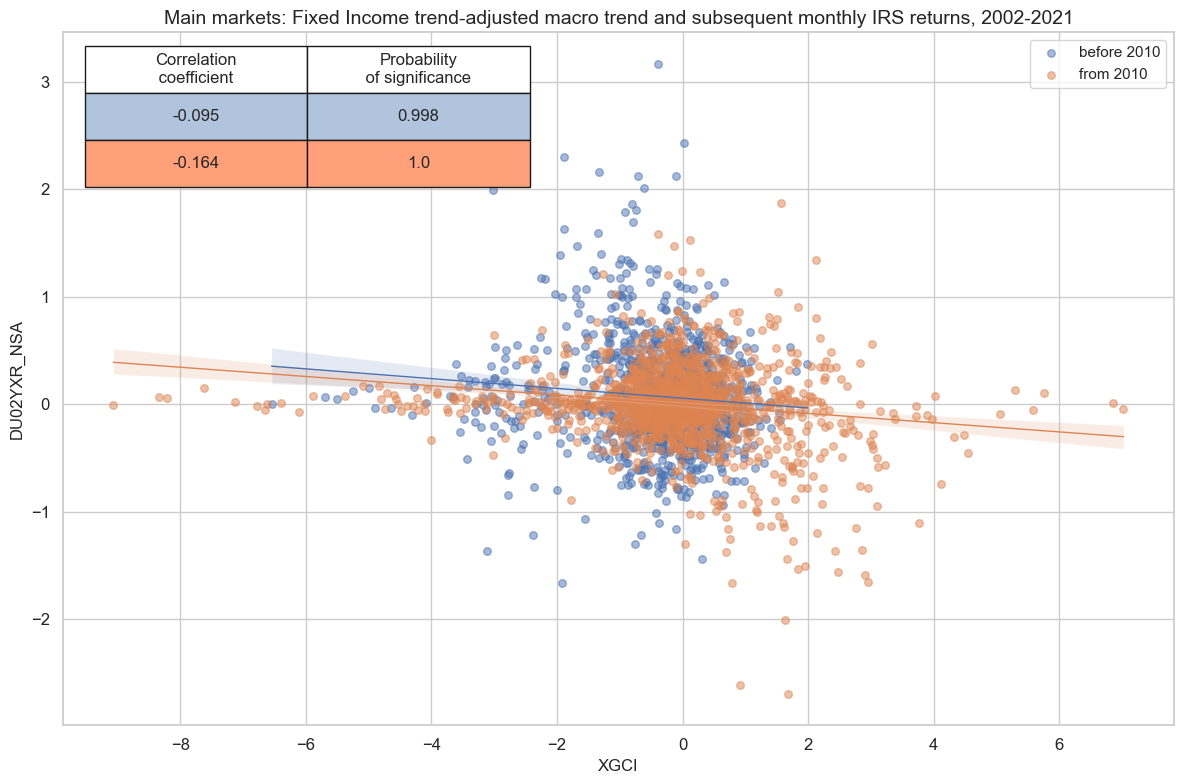

In [60]:
crm.reg_scatter(
    labels=False,
    coef_box="upper left",
    title="Main markets: Fixed Income trend-adjusted macro trend and subsequent monthly IRS returns, 2002-2021",
    xlab=None,
    ylab=None,
    size=(12,8),
    separator=2010,
)

Across markets, the negative relation between the composite macro trend and returns has been clearest in large countries. This makes a lot of sense since fixed-income returns in smaller countries often depend on the USD and EUR markets. Hence the macro trends in these countries have greater international importance and compete with local macro factors. By contrast, UK or Japan macro trends have typically little influence on the U.S. or the euro area.

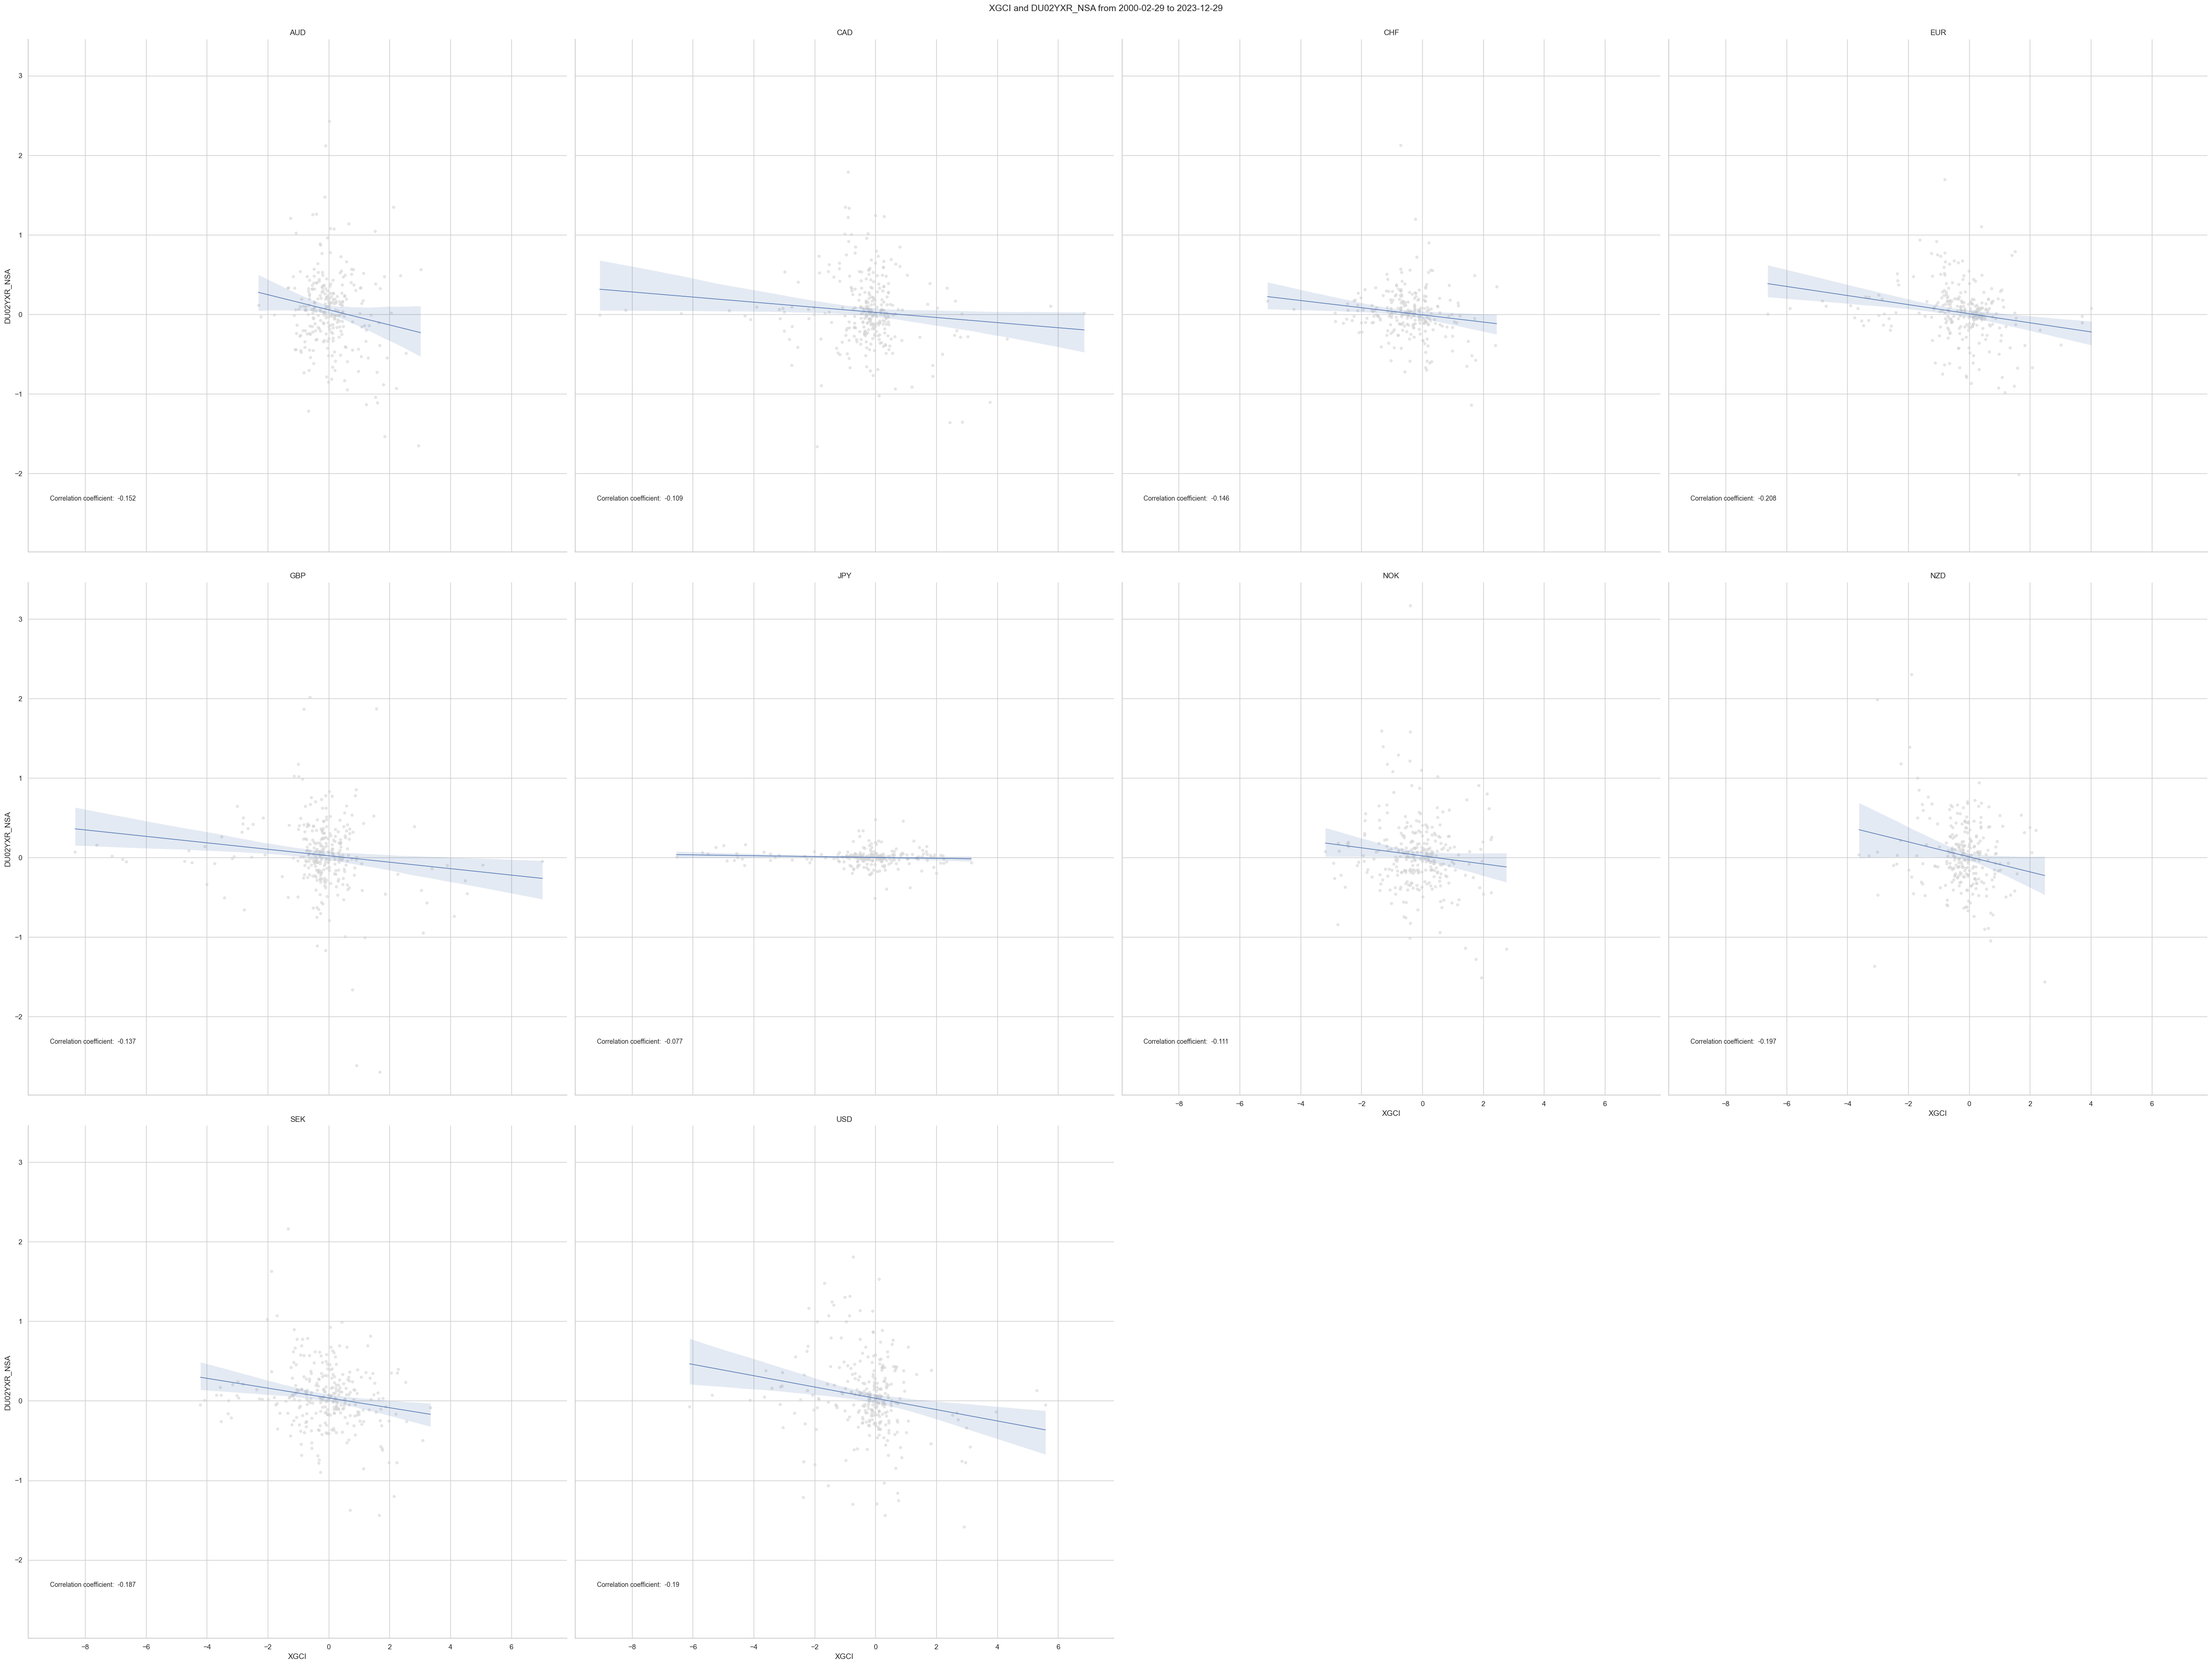

In [61]:
crm.reg_scatter(
    labels=True,
    coef_box="upper left",
    title=None,
    xlab=None,
    ylab=None,
    separator="cids",
    size=(12,12)
   
)

## How well do macro trends predict the direction of swap returns?

The `SignalReturnRelations` class of the `macrosynergy` package facilitates a quick assessment of the power of a signal category in predicting the direction of subsequent returns for data in JPMaQS format.

Monthly accuracy, i.e. the ratio of correctly predicted subsequent monthly returns, has been over 55% since 2000 for the G4 countries. Balanced accuracy, which averages the correct prediction of positive and negative returns, has similar values. Positive return predictions fared better than negative predictions.

In [62]:
xcats_sel = ["XGCI", "DU02YXR_NSA"]
srr = mss.SignalReturnRelations(
    df,
    cids=cids_dm,
    sigs=xcats_sel[0],
    sig_neg=True,  # use the negative of signal category
    rets=xcats_sel[1],
    freqs="M",
    start="2000-01-01",
)
srr.cross_section_table()
table= srr.cross_section_table()
style = table.style.background_gradient(cmap='Blues').format(precision=2)
style

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
M: XGCI_NEG/last => DU02YXR_NSA,0.55,0.55,0.59,0.54,0.58,0.52,0.14,0.00,0.09,0.00,0.55
Mean,0.55,0.55,0.59,0.54,0.58,0.53,0.15,0.04,0.09,0.11,0.55
PosRatio,1.00,1.00,1.00,1.00,1.00,0.70,1.00,1.00,1.00,1.00,1.00
AUD,0.56,0.55,0.51,0.56,0.61,0.50,0.15,0.01,0.05,0.20,0.55
CAD,0.53,0.52,0.64,0.52,0.54,0.51,0.11,0.06,0.06,0.11,0.52
CHF,0.59,0.60,0.70,0.52,0.58,0.62,0.15,0.02,0.10,0.01,0.58
EUR,0.59,0.59,0.54,0.55,0.63,0.55,0.21,0.00,0.17,0.00,0.59
GBP,0.54,0.53,0.64,0.53,0.55,0.51,0.14,0.02,0.10,0.01,0.53
JPY,0.55,0.54,0.58,0.55,0.59,0.49,0.08,0.25,0.04,0.42,0.54
NOK,0.53,0.53,0.59,0.51,0.54,0.53,0.11,0.06,0.05,0.22,0.53


Here is a brief explanations of the table (for full documentation see https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/signal/signal_return.py):


___accuracy___ refers accuracy for binary classification, i.e. positive or negative
            return, and gives the ratio of correct prediction of the sign of returns
            to all predictions. Note that exact zero values for either signal or
            return series will not be considered for accuracy analysis.<br />
___bal_accuracy___ refers to balanced accuracy. This is the average of the ratios of
            correctly detected positive returns and correctly detected negative returns.
            The denominators here are the total of actual positive and negative returns
            cases. Technically, this is the average of sensitivity and specificity.<br />
___pos_sigr___ is the ratio of positive signals to all predictions. It indicates the
            long bias of the signal.<br />
___pos_retr___ is the ratio of positive returns to all observed returns. It indicates
            the positive bias of the returns.<br />
___pos_prec___ means positive precision, i.e. the ratio of correct positive return
            predictions to all positive predictions. It indicates how well the positive
            predictions of the signal have fared. Generally, good positive precision is
            easy to accomplish if the ratio of positive returns has been high.<br />
___neg_prec___ means negative precision, i.e. the ratio of correct negative return
            predictions to all negative predictions. It indicates how well the negative
            predictions of the signal have fared. Generally, good negative precision is
            hard to accomplish if the ratio of positive returns has been high.<br />
___pearson___ is the Pearson correlation coefficient between signal and subsequent
            return.<br />
___pearson_pval___ is the probability that the (positive) correlation has been
            accidental, assuming that returns are independently distributed. This
            statistic would be invalid for forward moving averages.<br />
___kendall___ is the Kendall correlation coefficient between signal and subsequent
            return.<br />
___kendall_pval___ is the probability that the (positive) correlation has been
            accidental, assuming that returns are independently distributed. This
            statistic would be invalid for forward moving averages.<br />

_The rows have the following meaning:_<br />
___Panel___ refers to the the whole panel of cross sections and sample period,
            excluding unavailable and blacklisted periods.<br />
___Mean years___ is the mean of the statistic across all years.<br />
__Mean cids___ is the mean of the statistic across all sections.<br />
___Positive ratio___ is the ratio of positive years or cross sections for which the
            statistic was above its "neutral" level, i.e. above 0.5 for classification
            ratios and positive correlation probabilities and above 0 for the
            correlation coefficients.

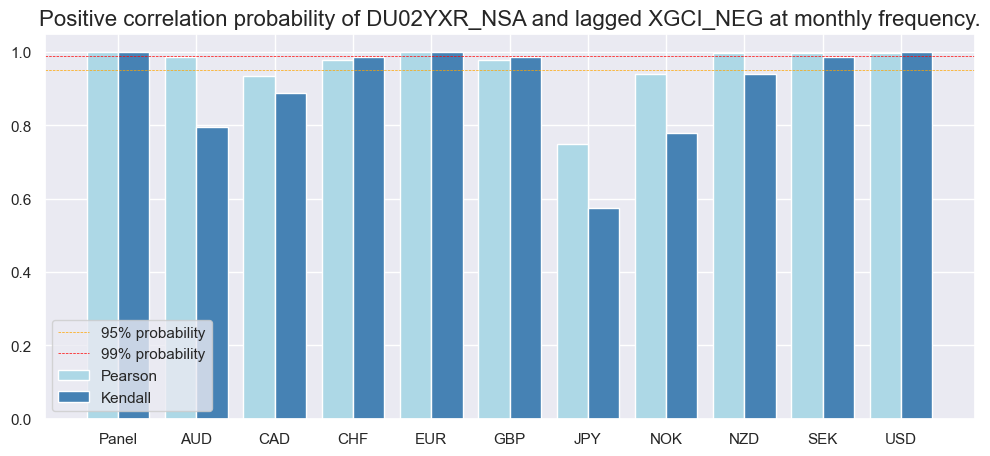

In [63]:
srr.correlation_bars(type="cross_section", size=(12, 5))

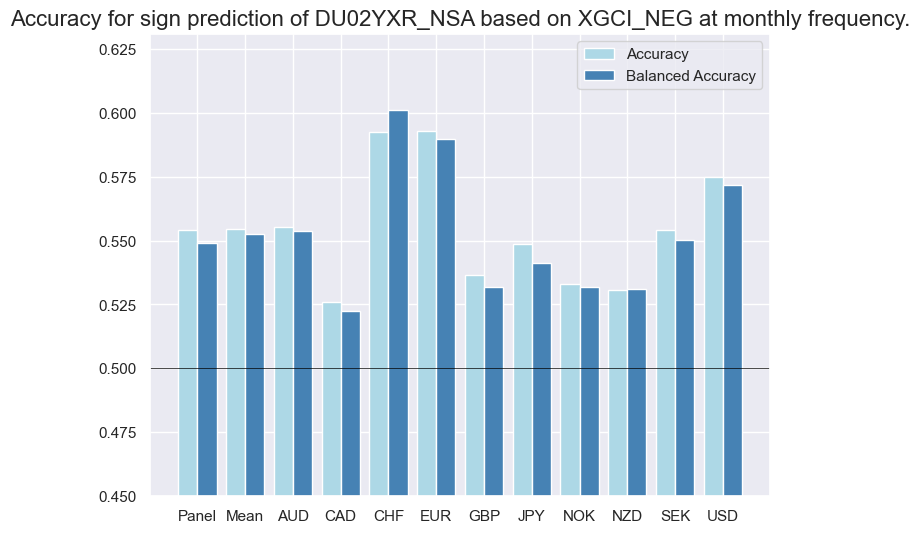

In [64]:
srr.accuracy_bars()